In [1]:
import pandas as pd
import networkx as nx
#get known complexes
datadir = '/home/dmoi/datasets/complexes/'
complexdf = pd.read_csv(datadir+'contactDefinition.txt' , sep='\t')
print(complexdf.head())

     code ch1 ch2  nres  len1  len2 dom_s1      dom_p1 dom_s2      dom_p2  \
0  4rk1_1   A   B  31.0   267   268  53822   PF13377.1  53822   PF13377.1   
1  2gqn_1   D   B  53.0   392   392  53383  PF01053.15  53383  PF01053.15   
2  2gqn_1   D   C  17.0   392   391  53383  PF01053.15  53383  PF01053.15   
3  2gqn_1   A   C  52.0   391   391  53383  PF01053.15  53383  PF01053.15   
4  2gqn_1   A   D  28.5   391   392  53383  PF01053.15  53383  PF01053.15   

   ident  homo  
0      1   1.0  
1      1   1.0  
2      1   1.0  
3      1   1.0  
4      1   1.0  


<Axes: >

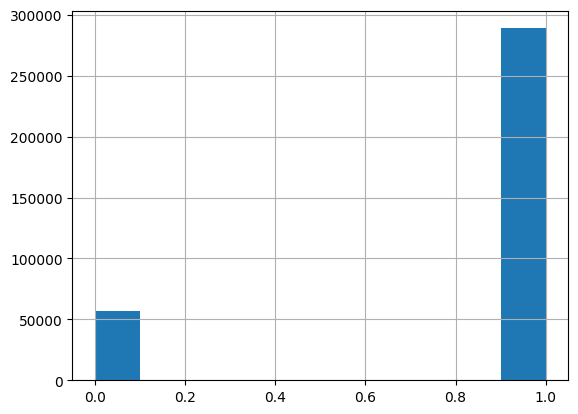

In [8]:
complexdf.homo.hist()

In [2]:
complexdf['accession'] = complexdf.code.map(lambda x: x.split('_')[0])

In [3]:
import glob
pdbs = glob.glob(datadir+'BU_all_renum/*.pdb')
#remove fixed 
pdbs = [p for p in pdbs if 'fixed' not in p]
print(len(pdbs))

173593


In [4]:
codes = { f.split('/')[-1].split('.')[0]:f for f in pdbs}
complexdf['pdbfile'] = complexdf['code'].map(codes)
print(complexdf.head())

     code ch1 ch2  nres  len1  len2 dom_s1      dom_p1 dom_s2      dom_p2  \
0  4rk1_1   A   B  31.0   267   268  53822   PF13377.1  53822   PF13377.1   
1  2gqn_1   D   B  53.0   392   392  53383  PF01053.15  53383  PF01053.15   
2  2gqn_1   D   C  17.0   392   391  53383  PF01053.15  53383  PF01053.15   
3  2gqn_1   A   C  52.0   391   391  53383  PF01053.15  53383  PF01053.15   
4  2gqn_1   A   D  28.5   391   392  53383  PF01053.15  53383  PF01053.15   

   ident  homo accession                                            pdbfile  
0      1   1.0      4rk1  /home/dmoi/datasets/complexes/BU_all_renum/4rk...  
1      1   1.0      2gqn  /home/dmoi/datasets/complexes/BU_all_renum/2gq...  
2      1   1.0      2gqn  /home/dmoi/datasets/complexes/BU_all_renum/2gq...  
3      1   1.0      2gqn  /home/dmoi/datasets/complexes/BU_all_renum/2gq...  
4      1   1.0      2gqn  /home/dmoi/datasets/complexes/BU_all_renum/2gq...  


In [5]:
#sample 2000 codes
import random
sub = complexdf.code.unique().tolist()
random.shuffle(sub)
sub = sub[:2000]
sub = complexdf[complexdf.code.isin(sub)]
print(sub.head())
print( len(sub) )

       code ch1 ch2  nres  len1  len2       dom_s1                 dom_p1  \
14   2pw0_2   A   B  50.0   386   342  54506;54506              PF04303.8   
91   3t34_1   A   B  24.5   335   341        52540  PF00350.18;PF01031.15   
487  4wr8_4   K   L  24.5   114   114        55331             PF01187.13   
488  4wr8_4   J   K  23.5   114   114        55331             PF01187.13   
489  4wr8_4   J   L  25.5   114   114        55331             PF01187.13   

          dom_s2                 dom_p2  ident  homo accession  \
14   54506;54506              PF04303.8      1   1.0      2pw0   
91         52540  PF00350.18;PF01031.15      1   1.0      3t34   
487        55331             PF01187.13      1   1.0      4wr8   
488        55331             PF01187.13      1   1.0      4wr8   
489        55331             PF01187.13      1   1.0      4wr8   

                                               pdbfile  
14   /home/dmoi/datasets/complexes/BU_all_renum/2pw...  
91   /home/dmoi/datasets/c

In [ ]:
nonhomodimer = sub[sub['homo'] != 1 ]
print(nonhomodimer.head())
print(len(nonhomodimer))

        code ch1 ch2  nres  len1  len2       dom_s1  \
976   4hgk_1   A   D  14.5   483   104  48552;48552   
1647  3l5x_1   A   H   9.0   101   223        47266   
1648  3l5x_1   A   L   2.5   101   214        47266   
4234  4y6g_1   D   C  28.5   396   257        53686   
4235  4y6g_1   A   B  28.5   257   396        51366   

                                dom_p1       dom_s2                 dom_p2  \
976   PF00273.15;PF00273.15;PF00273.15        48726             PF07686.12   
1647                         PF03487.8          NaN  PF07686.12;PF07654.10   
1648                         PF03487.8  48726;48726  PF07686.12;PF07654.10   
4234                        PF00291.20        51366             PF00290.15   
4235                        PF00290.15        53686             PF00291.20   

      ident  homo accession                                            pdbfile  
976       0   0.0      4hgk  /home/dmoi/datasets/complexes/BU_all_renum/4hg...  
1647      0   0.0      3l5x  /home/dmo

In [17]:
#create a graph for each code
import networkx as nx
import tqdm
graphs = {}
for code in tqdm.tqdm(nonhomodimer.code.unique()):
	sub = complexdf[complexdf.code == code ]
	chains = set( sub.ch1 ).union( set( sub.ch2 ))
	g = nx.MultiGraph()
	#add edges for homology and interaction
	g.add_edges_from( [ (  r.ch1 , r.ch2 , 'interaction' ) for idx, r in sub.iterrows()  ])
	g.add_edges_from( [ (  r.ch1 , r.ch2 , 'homology' ) for idx, r in sub.iterrows()  if r.homo == 1])
	graphs[code] = g
	

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:12<00:00, 33.73it/s]


MultiGraph with 4 nodes and 8 edges


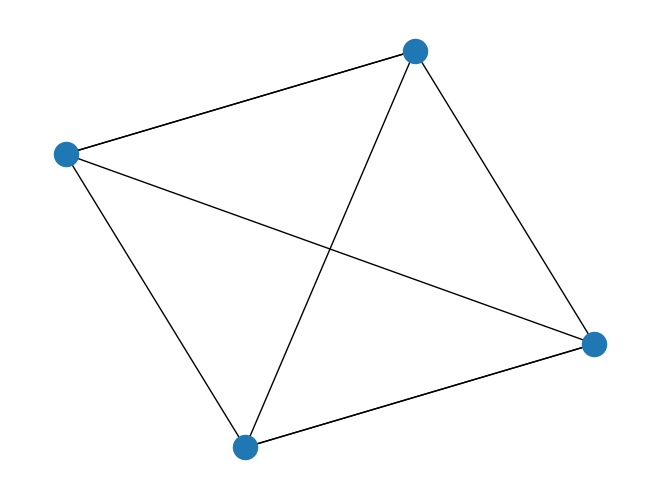

In [ ]:
g =  graphs[ nonhomodimer.code.iloc[10]]
print(  g )
nx.draw( g ) 

In [9]:
print( sub.pdbfile.unique() )
print( len(sub.pdbfile.unique() ) )

['/home/dmoi/datasets/complexes/BU_all_renum/1dfj_1.pdb'
 '/home/dmoi/datasets/complexes/BU_all_renum/2eba_1.pdb'
 '/home/dmoi/datasets/complexes/BU_all_renum/3njn_2.pdb' ...
 '/home/dmoi/datasets/complexes/BU_all_renum/5jk6_1.pdb'
 '/home/dmoi/datasets/complexes/BU_all_renum/5j9t_3.pdb'
 '/home/dmoi/datasets/complexes/BU_all_renum/5g2s_1.pdb']
2000


In [7]:
#run pdbfixer on all pdbs
from pdbfixer import PDBFixer
from openmm.app import PDBFile
import tqdm
import os
import pebble 
import concurrent.futures

def fix_pdb(pdbfile):
    try:
        if os.path.exists(pdbfile.replace('.pdb', '_fixed.pdb')):
            return pdbfile.replace('.pdb', '_fixed.pdb')
        
        fixer = PDBFixer(filename=pdbfile)  
        fixer.findMissingResidues()
        fixer.findNonstandardResidues()
        fixer.replaceNonstandardResidues()
        fixer.removeHeterogens(True)
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        outfile = pdbfile.replace('.pdb', '_fixed.pdb')
        with open(outfile, 'w') as w:
            PDBFile.writeFile(fixer.topology, fixer.positions, w)
        return outfile
    except Exception as e:
        print(e)
        return None
    

fix_pdbs = False
if fix_pdbs == True:
    with pebble.ProcessPool() as pool:
        futures = pool.map(fix_pdb, tqdm.tqdm(sub.pdbfile.unique().tolist()), timeout=60, workers=8, chunksize=8)
        results = []
        for future in tqdm.tqdm(concurrent.futures.as_completed(futures)):
            try:
                result = future.result()
                print(result)
                results.append(result)
            except TimeoutError as e:
                print(e)
            except Exception as e:
                print("Error processing PDB:", e)

    # Add fixed filepaths to sub
    sub['fixed_pdb'] = results
    print( sub.head())

In [8]:
fixed = glob.glob(datadir+'BU_all_renum/*_fixed.pdb')
print( len(fixed) )
print( fixed[:20] )

2712
['/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/2dft_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/2qwv_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/1kpv_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/4huk_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/5g2z_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/1eqg_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/2i3v_7_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/1pjh_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/3kx8_3_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/4bxc_2_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/2uzl_1_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/3hsq_3_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_all_renum/4i0x_6_fixed.pdb', '/home/dmoi/datasets/foldtree2/complexes/BU_a

In [ ]:
#get pdb ids from fixed
fixed = {f.split('/')[-1].split('_')[0]:f for f in fixed}
print( len(fixed) )
#filter complex df to only fixed pdbs
sub = complexdf[complexdf.accession.isin(fixed.keys())]
sub['fixed_pdb'] = sub.accession.map(fixed)
print(sub.head())
print( len(sub) )


2664
       code ch1 ch2  nres  len1  len2                         dom_s1  \
16   1z42_2   A   B  21.0   337   337                          51395   
41   4yiq_2   D   C  17.5   108   107                            NaN   
89   3wgo_1   A   B  56.0   323   324        51735_f1;55347;51735_f2   
112  1t8m_6   A   D   7.0   239    58                          50494   
113  3zmt_1   A   B  48.0   665   133  46689;51905_f1;54373;51905_f2   

                    dom_p1                   dom_s2      dom_p2  ident  homo  \
16              PF00724.15                    51395  PF00724.15      1   1.0   
41              PF07686.12                      NaN  PF07686.12      0   1.0   
89              PF01113.15  51735_f1;55347;51735_f2  PF01113.15      1   1.0   
112             PF00089.21                    57362  PF00014.18      0   0.0   
113  PF04433.12;PF01593.19             267603;46689  PF00249.26      0   0.0   

    accession                                            pdbfile  \
16       1z42

/tmp/ipykernel_69048/343266994.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['fixed_pdb'] = sub.accession.map(fixed)


In [19]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [29]:
#make a complex dataset of pytorch geometric objects
import sys
sys.path.append('/home/dmoi/projects/foldtree2/')

import foldtree2_ecddcd as ft2
import importlib
importlib.reload(ft2)

converter = ft2.PDB2PyG()
store_complexes = False
if store_complexes == True:
    converter.store_pyg_complexdata(sub.fixed_pdb.unique() , datadir+'pyg_complexes.h5' , verbose = False)

In [30]:
#load complex dataset
comp_dataset = ft2.ComplexDataset( datadir+'pyg_complexes.h5' )
print(len(comp_dataset.structlist))
chains,complexes = comp_dataset[20]
print(chains, complexes)

2659
{'0': HeteroData(
  identifier='1al7_2_fixed',
  AA={ x=[359, 20] },
  plddt={ x=[359, 1] },
  positions={ x=[359, 256] },
  res={ x=[359, 844] },
  (res, backbone, res)={
    edge_index=[2, 1075],
    edge_attr=[358],
  },
  (res, backbonerev, res)={
    edge_index=[2, 717],
    edge_attr=[358],
  },
  (res, contactPoints, res)={
    edge_index=[2, 3602],
    edge_attr=[3602],
  },
  (res, hbond, res)={
    edge_index=[2, 236],
    edge_attr=[236],
  }
), '10': HeteroData(
  identifier='1al7_2_fixed',
  AA={ x=[350, 20] },
  plddt={ x=[350, 1] },
  positions={ x=[350, 256] },
  res={ x=[350, 844] },
  (res, backbone, res)={
    edge_index=[2, 1048],
    edge_attr=[349],
  },
  (res, backbonerev, res)={
    edge_index=[2, 699],
    edge_attr=[349],
  },
  (res, contactPoints, res)={
    edge_index=[2, 3514],
    edge_attr=[3514],
  },
  (res, hbond, res)={
    edge_index=[2, 228],
    edge_attr=[228],
  }
), '12': HeteroData(
  identifier='1al7_2_fixed',
  AA={ x=[350, 20] },
  pl

In [117]:
from scipy.stats import bernoulli
import random 
import torch

def find_pairs(chains, comlexes):
    #go through all pairs in complexes. select those with an edge index that is not empty
    pairs = {}
    for c1 in chains:
        print(c1,c2)
        print(complexes[c1 +'_'+ c2][('res', 'contactPointsComplex', 'res')] ) 
        print(complexes[c1 +'_'+ c2])
        edge_index = complexes[c1 +'_'+ c2][('res', 'contactPointsComplex', 'res')].edge_index
        if edge_index.size(1) > 0:
            pairs[c1+'_'+c2] = complexes[c1 +'_'+ c2]
    
    #select a random pair
    pairs = {k:pairs[k] for k in random.sample(list(pairs.keys()), 1)}    
    return pairs

def complex_loader(comp_dataset , neg_samples=.50 ,  batchsize = 10):

    allstructs = comp_dataset.structlist 
    while True:
        if bernoulli.rvs(neg_samples) == 1:
            #positive sample
            s = random.choice(allstructs)
            chains,complexes = comp_dataset[s]
            complexes = find_pairs(chains, complexes)
            chains = {k.split('_')[0]:chains[k.split('_')[0]] for k in pairs}
            yield chains,complexes,torch.tensor([1.0])
            #sample a complex
        else:
            #negative sample
            s1 = random.choice(allstructs)
            s2 = random.choice(allstructs)
            while s1 == s2:
                s2 = random.choice(allstructs)
            chains1,complexes1 = comp_dataset[s1]
            chains2,complexes2 = comp_dataset[s2]
            #select a random chain from each complex
            chain1 = random.choice(list(chains1.keys()))
            chain2 = random.choice(list(chains2.keys()))
            chains = {chain1:chains1[chain1], chain2:chains2[chain2]}
            #complexes has just an empty tensor with 2 dimensions
            complexes = {chain1+'_'+chain2:torch.tensor([])}
            #draw two random chains from different complexes
            yield chains,complexes,torch.tensor([0.0])

In [118]:
loader = complex_loader(comp_dataset)
print( next(loader) )

0 1
{'edge_index': tensor([], size=(2, 0), dtype=torch.int64)}
HeteroData(
  identifier='1a4h_1_fixed',
  (res, contactPointsComplex, res)={},
  (res, contactPointsComplex, res)={ edge_index=[2, 0] }
)


ValueError: Sample larger than population or is negative

In [ ]:
from torch_geometric.data import HeteroData
#import sageconv
from torch_geometric.nn import SAGEConv , Linear , FiLMConv , TransformerConv , FeaStConv , GATConv , GINConv , GatedGraphConv
#import module dict and module list
from torch.nn import ModuleDict, ModuleList , L1Loss
from torch_geometric.nn import global_mean_pool
#import negative sampling
from torch_geometric.utils import negative_sampling

EPS = 1e-10

def recon_loss_complex( z1: Tensor,z2: Tensor, pos_edge_index: Tensor , backbone1:Tensor = None ,backbone2:Tensor = None , decoder = None , poslossmod = 1 , neglossmod= 1) -> Tensor:
    r"""Given latent variables :obj:`z`, computes the binary cross
    entropy loss for positive edges :obj:`pos_edge_index` and negative
    sampled edges.

    Args:
        z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
        pos_edge_index (torch.Tensor): The positive edges to train against.
        neg_edge_index (torch.Tensor, optional): The negative edges to
            train against. If not given, uses negative sampling to
            calculate negative edges. (default: :obj:`None`)
    """
    
    pos =decoder(z1,z2, pos_edge_index, { ( 'res','backbone','res'): backbone1 } , { ( 'res','backbone','res'): backbone2 } )[1]
    #turn pos edge index into a binary matrix
    pos_loss = -torch.log( pos + EPS).mean()
    neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
    neg = decoder(z1 , z2, neg_edge_index, { ( 'res','backbone','res'): backbone1 } , { ( 'res','backbone','res'): backbone2 } )[1]
    neg_loss = -torch.log( ( 1 - neg) + EPS ).mean()
    return poslossmod*pos_loss + neglossmod*neg_loss


In [34]:
from torch_geometric.nn import SAGEConv , Linear
from torch.nn import Sigmoid, ModuleDict

class HeteroGAE_Pairwise_Decoder(torch.nn.Module):
    #we don't need to decode to aa... just contact probs
    def __init__(self, encoder_out_channels, xdim=20, hidden_channels={'res_backbone_res': [20, 20, 20]}, out_channels_hidden=20, nheads = 1 , Xdecoder_hidden=30, metadata={}, amino_mapper= None):
        super(HeteroGAE_Pairwise_Decoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.metadata = metadata
        self.hidden_channels = hidden_channels
        self.out_channels_hidden = out_channels_hidden
        self.in_channels = encoder_out_channels
        for i in range(len(self.hidden_channels[('res', 'backbone', 'res')])):
            self.convs.append(
                torch.nn.ModuleDict({
                    '_'.join(edge_type): SAGEConv(self.in_channels if i == 0 else self.hidden_channels[edge_type][i-1], self.hidden_channels[edge_type][i]  )
                    for edge_type in [('res', 'backbone', 'res')]
                })
            )
        self.lin = Linear(hidden_channels[('res', 'backbone', 'res')][-1], self.out_channels_hidden)
        self.sigmoid = Sigmoid()
    def forward(self, z1, z2, edge_index, backbones, **kwargs):
        zs = []
        for z in [z1,z2]:
            inz = z
            for layer in self.convs:
                for edge_type, conv in layer.items():
                    z = conv(z, backbones[tuple(edge_type.split('_'))])
                    z = F.relu(z)
            z = self.lin(z)
            zs.append(z)
        sim_matrix = (zs[0][edge_index[0]] * zs[1][edge_index[1]]).sum(dim=1)
        edge_probs = self.sigmoid(sim_matrix)
        
        return edge_probs

In [40]:
import torch
import pickle
import os

ndim = 844
converter = ft2.PDB2PyG()
with open( 'model.pkl' , 'rb' ) as f:
    encoder, d = pickle.load( f )
alphabetsize = encoder.vector_quantizer.embedding_dim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = encoder.to(device)
encoder.eval()

#create new decoder
decoder = HeteroGAE_Pairwise_Decoder(encoder_out_channels = encoder.out_channels , 
                            hidden_channels={ ( 'res','backbone','res'):[ 300 ] * 5  } , 
                            out_channels_hidden= 150 , metadata={} , Xdecoder_hidden=100 )

decoder_save = 'decoder_complex1st'
#put encoder and decoder on the device
decoder = decoder.to(device)

# Create a DataLoader for training
total_loss_x = 0
total_loss_edge = 0
total_vq=0
total_kl = 0
total_plddt=0
# Training loop
if os.path.exists(decoder_save):
    decoder.load_state_dict(torch.load(decoder_save))
    print("loaded encoder and decoder")


In [ ]:
train_loader = DataLoader(struct_dat, batch_size=40, shuffle=True)
optimizer = torch.optim.Adam( list(decoder.parameters()), lr=0.001)
encoder.eval()
decoder.train()
edgelosses = []
edgeweight = 1
for epoch in range(1000):
    for nsteps,data in tqdm.tqdm(enumerate(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        z1 = encoder(data['res'].x, data['AA'].x , data.edge_index_dict)
        z2 = encoder(data['res'].x, data['AA'].x , data.edge_index_dict)
        #add positional encoding to give to the decoder
        edgeloss = recon_loss(z1,z2, , data.edge_index_dict[( 'res','contactPoints','res')] , data.edge_index_dict[( 'res','backbone','res')], decoder)
        loss =  edgeweight*edgeloss
        total_loss_edge += edgeloss.item()
        if nsteps % batchsize == 0:
            loss.backward()
            optimizer.step()
            
    if epoch % 100 == 0 :
        #save model
        torch.save(decoder.state_dict(), decoder_save)
        with open('decoder_complex.pkl' , 'wb') as out:
            out.write( pickle.dumps( decoder ) )
    print(f'Epoch {epoch}, Edge Loss: {total_loss_edge:.4f}') 
    total_loss_edge = 0
    #total_plddt = 0
torch.save(decoder.state_dict(), decoder_save)
with open('decoder_complex.pkl' , 'wb') as out:
    out.write( pickle.dumps( decoder ) )

In [ ]:
#brainstorming to get complex graphs...

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer

class GraphGenerationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead, num_encoder_layers, num_decoder_layers, num_classes):
        super(GraphGenerationModel, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(d_model=input_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        
        self.decoder_layer = TransformerDecoderLayer(d_model=output_dim, nhead=nhead)
        self.transformer_decoder = TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        
        self.node_mlp = nn.Linear(output_dim, num_classes + 1)  # +1 for EOS token
        self.edge_mlp = nn.Linear(2 * output_dim, 1)
        self.embedding = nn.Embedding(num_classes + 1, output_dim)
        
    def encode(self, x):
        return self.transformer_encoder(x)
    
    def decode(self, z, memory):
        return self.transformer_decoder(z, memory)
    
    def forward(self, x, max_length=20):
        # Encode the input sequence using the transformer encoder
        memory = self.encode(x)  # Shape: [batch_size, seq_len, input_dim]
        
        # Start with an initial input (e.g., a start token)
        start_token = torch.zeros((memory.size(0), 1, memory.size(-1)), device=x.device)
        z = start_token
        
        node_logits = []
        for _ in range(max_length):
            z = self.decode(z, memory)
            node_logit = self.node_mlp(z[:, -1, :])  # Take the last token's output
            node_logits.append(node_logit)
            
            # Get the next input token (embedding of the predicted class)
            next_token = node_logit.argmax(dim=-1).unsqueeze(1)
            next_token_embedding = self.embedding(next_token)
            z = torch.cat([z, next_token_embedding], dim=1)
            
            if (next_token == num_classes).all():  # EOS token
                break
        
        node_logits = torch.stack(node_logits, dim=1)
        
        # Decode edges (fully connected example, customize as needed)
        num_nodes = node_logits.size(1)
        edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()
        edge_features = torch.cat([node_logits[:, edge_index[0]], node_logits[:, edge_index[1]]], dim=-1)
        edge_logits = self.edge_mlp(edge_features).squeeze(-1)
        edge_probs = torch.sigmoid(edge_logits)
        
        return node_logits, edge_index, edge_probs

# Example usage
input_dim = 10   # Dimension of input embeddings
hidden_dim = 32  # Dimension of hidden layer
output_dim = 16  # Dimension of node features
nhead = 2        # Number of heads in the multi-head attention
num_encoder_layers = 2  # Number of transformer encoder layers
num_decoder_layers = 2  # Number of transformer decoder layers
num_classes = 5  # Number of node categories (excluding EOS token)

model = GraphGenerationModel(input_dim, hidden_dim, output_dim, nhead, num_encoder_layers, num_decoder_layers, num_classes)

# Example input: batch of sequences (batch_size, seq_len, input_dim)
x = torch.randn(5, 10, input_dim)  # Batch of 5 sequences, each of length 10

node_logits, edge_index, edge_probs = model(x)
print("Node logits:\n", node_logits)
print("Edge index:\n", edge_index)
print("Edge probabilities:\n", edge_probs)


In [ ]:
import tqdm
import pickle
chunksize = 10000
graphs = {}
for code in tqdm.tqdm(complexdf.code.unique()):
    sub = complexdf[complexdf.code == code]
    chains = set(sub.ch1.unique()).union( set( sub.ch2.unique() ))
    #add chains to graph
    G = nx.MultiGraph()
    G.add_nodes_from(chains)
    for i, row in sub.iterrows():
        #homology link
        if row.homo == 1:
            #add homology type edge
            ekey = G.add_edge(row.ch1, row.ch2, key='homology' )
        #add contact type edge
        ekey = G.add_edge(row.ch1, row.ch2, key='contact' )
    graphs[code] = G

with open('complexgraphs.pkl' , 'wb') as graphsout:
    graphsout.write( pickle.dumps( graphs ) )

#embed all structures
#use decoder and generate z vecs
#use decoder sigmoid to get contact proba

 40%|█████████████████████████████▊                                            | 36180/89764 [10:45<15:56, 56.02it/s]


KeyboardInterrupt: 

In [ ]:
import torch.optim as optim

def train(model, dataloader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    edge_loss_fn = nn.BCELoss()  # Loss function for edge probabilities
    node_loss_fn = nn.NLLLoss()  # Loss function for node classification

    for epoch in range(epochs):
        model.train()
        total_edge_loss = 0
        total_node_loss = 0

        for sequences, graphs, node_labels in dataloader:
            optimizer.zero_grad()
            
            node_logits, edge_index, edge_probs = model(sequences)

            # Flatten the edge probabilities and create a target tensor
            target_edge_probs = torch.cat([graph.edge_index for graph in graphs], dim=1)
            target = torch.ones(target_edge_probs.size(1))  # Example target, customize as needed

            # Compute edge loss
            edge_loss = edge_loss_fn(edge_probs, target)

            # Compute node classification loss
            node_labels = node_labels.view(-1)
            node_classes = node_logits.view(-1, num_classes + 1)  # +1 for EOS token
            node_loss = node_loss_fn(node_classes, node_labels)

            # Total loss
            loss = edge_loss + node_loss
            loss.backward()
            optimizer.step()

            total_edge_loss += edge_loss.item()
            total_node_loss += node_loss.item()

        print(f"Epoch {epoch+1}, Edge Loss: {total_edge_loss / len(dataloader)}, Node Loss: {total_node_loss / len(dataloader)}")

# Train the model
train(model, dataloader)
